In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import redis
from automlp import parameters, automlp

In [3]:
%%writefile /tmp/redis.conf
daemonize yes
pidfile /var/run/redis/redis-server.pid
port 6379
bind 127.0.0.1
timeout 0
logfile /tmp/redis-server.log
appendonly no
save ""

Overwriting /tmp/redis.conf


In [4]:
!pkill -9 redis-server
!redis-server /tmp/redis.conf

OrderedDict([('lr', 0.0018620338722770715), ('batch_size', 162)])
20


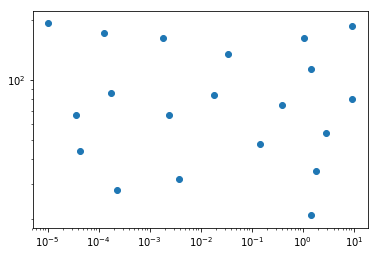

In [5]:
reload(parameters)
reload(automlp)
ps = parameters.ParameterSet()
ps += parameters.LogParameter("lr", 1e-5, 1e1)
ps += parameters.QuantizedLogParameter("batch_size", 20, 200)
ex = parameters.Exploration(ps)
ex.redis_connect(key="ex", clear=True, host="localhost")
picks = [ex.pick_farthest(record=True) for i in range(20)]
print(picks[0])
xs = [r["lr"] for r in picks]
ys = [r["batch_size"] for r in picks]
xscale('log'); yscale('log')
scatter(xs, ys)
print(ex.red.llen("ex.results"))

20
20
220


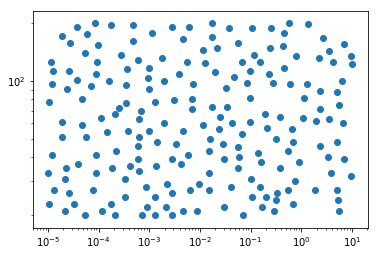

In [6]:
ex2 = parameters.Exploration(ps)
ex2.redis_connect(key="ex", clear=False, host="localhost")
print(ex2.red.llen("ex.results"))
print(len(ex2.results))
picks = [ex2.pick_farthest(record=True) for i in range(200)]
print(len(ex2.results))
xs = [r["lr"] for r in picks]
ys = [r["batch_size"] for r in picks]
xscale('log'); yscale('log')
scatter(xs, ys)

In [7]:
print(ex.red.llen("ex.results"))

220


In [8]:
import torch
from torch import nn
from torchvision.datasets import mnist
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class MnistAdapter(object):
    def __init__(self, ds):
        self.ds = ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, index):
        inputs, targets = self.ds[index]
        return torch.FloatTensor(np.array(inputs)/255.0).reshape(-1), int(targets)

data = MnistAdapter(mnist.MNIST("./_data", download=True))
test_data = MnistAdapter(mnist.MNIST("./_data", download=True, train=False))

def make_model():
    return nn.Sequential(nn.Linear(28*28, 20),
                         nn.ReLU(),
                         nn.Linear(20, 10))

In [9]:
reload(parameters)

ps = parameters.ParameterSet()
ps += parameters.LogParameter("lr", 1e-5, 1e1)
ps += parameters.QuantizedLogParameter("batch_size", 20, 200)

ex = parameters.Exploration(ps)
ex.redis_connect(key="ex", clear=True, host="localhost")

for trial in range(100):
    if len(ex)>=50: break
    pv = ex.pick_farthest()
    model = make_model()
    model.cuda()
    trainer = automlp.Trainer(model, "crossentropy")
    model.META["params"] = pv
    for epoch in range(5):
        trainer.train_dataset(data, options=pv, ntrain=10000)
        loss = trainer.evaluate_classification(test_data)
    model.cpu()
    key = ex.save_model(model)
    print(trial, len(ex), loss, pv, key)
    ex.add_result(pv, loss, key)

(0, 0, 0.9018, OrderedDict([('lr', 4.7792946452210865), ('batch_size', 59)]), 'de6a4648de1911e894d20242ac110003')
(1, 1, 0.8412, OrderedDict([('lr', 5.945402576399019e-05), ('batch_size', 108)]), 'e30a59a4de1911e894d20242ac110003')
(2, 2, 0.1786, OrderedDict([('lr', 0.0003502700962137739), ('batch_size', 28)]), 'e95ddc04de1911e894d20242ac110003')
(3, 3, 0.0906, OrderedDict([('lr', 0.03597558851078342), ('batch_size', 177)]), 'ee1e82dede1911e894d20242ac110003')
(4, 4, 0.0703, OrderedDict([('lr', 0.0669873843065499), ('batch_size', 34)]), 'f42482fade1911e894d20242ac110003')
(5, 5, 0.1409, OrderedDict([('lr', 0.001626868188967468), ('batch_size', 73)]), 'f9443c9ede1911e894d20242ac110003')
(6, 6, 0.9108, OrderedDict([('lr', 3.0531867392152647), ('batch_size', 20)]), 'ffe7cec6de1911e894d20242ac110003')
(7, 7, 0.9092, OrderedDict([('lr', 1.4967617984219546e-05), ('batch_size', 168)]), '04752be6de1a11e894d20242ac110003')
(8, 8, 0.7573, OrderedDict([('lr', 1.2500382992206238e-05), ('batch_size

In [13]:
import simplejson
metas = [simplejson.loads(v) for v in ex.red.hvals("ex.metas")]
metas[0]["log"][:3]

[{'key': 'options',
  'ntrain': 0,
  'options': {'batch_size': 168, 'lr': 1.4967617984219546e-05},
  'time': 1541106388.380458},
 {'key': 'train',
  'loss': 2.313247417999526,
  'ntrain': 9912,
  'time': 1541106389.205989},
 {'key': 'eval',
  'loss': 0.916,
  'ntrain': 9912,
  'time': 1541106389.915469,
  'total': 10000,
  'type': 'classification'}]

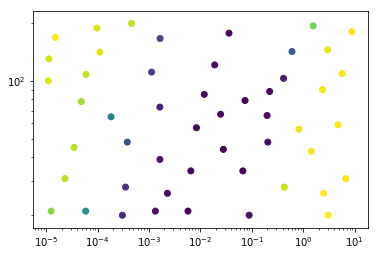

In [14]:
import simplejson
metas = [simplejson.loads(v) for v in ex.red.hvals("ex.metas")]
losses = array([(l["params"]["lr"], l["params"]["batch_size"], l["loss"])  for l in metas])
xscale('log'); yscale('log')
scatter(losses[:,0], losses[:,1], c=losses[:,2])

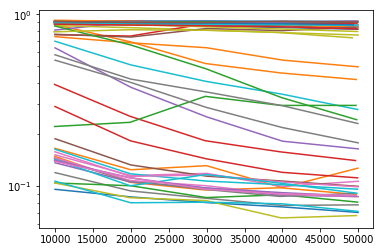

In [15]:
losses = [[(r["ntrain"], r["loss"]) for r in meta["log"] if r["key"]=="eval"] for meta in metas]
yscale("log")
for l in losses: plot(*zip(*l))

In [16]:
!pkill -f redis-server